<p align="left">
  <img width="100%" src="docs/Banner.png">
</p>    

# InSAR Time Series Analysis: MintPy + ARIA GUNW products

**Author:** Zhang Yunjun, Heresh Fattahi, August 10-14, 2020 @UNAVCO (virtual)

The Miami INsar Timeseries software in PYthon (MintPy) is an open-source package for InSAR time-series analysis. MintPy currently starts from stacks of unwrapped interferograms (in either geo- or radar-coordinates) and estimates ground displacement time-series. MintPy is primarily consistent with stacks of interferograms processed with ISCE. However, the software also supports interfarograms processed with other InSAR processors such as GAMMA, SNAP and ROI_PAC. 

MintPy is available on Github from the following page: https://github.com/insarlab/MintPy

References: The detailed algorithms implemented in MintPy can be found in the following manuscript: 

+ Yunjun, Z., H. Fattahi, F. Amelung (2019), Small baseline InSAR time series analysis: Unwrapping error correction and noise reduction, _Computers & Geosciences, 133,_ 104331, doi:[10.1016/j.cageo.2019.104331](https://doi.org/10.1016/j.cageo.2019.104331), [arXiv](https://eartharxiv.org/9sz6m/).

# 0. Initial setup of the notebook

The cell below performs the intial setup of the notebook and must be **run every time the notebook (re)starts**. It defines the processing location and check the example dataset.

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
# verify mintpy install
try:
    from mintpy.objects.insar_vs_gps import plot_insar_vs_gps_scatter
    from mintpy.unwrap_error_phase_closure import plot_num_triplet_with_nonzero_integer_ambiguity
    from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix
except ImportError:
    raise ImportError("Can not import mintpy!")

# utils function
def configure_template_file(outName, CONFIG_TXT): 
    """Write configuration files for MintPy to process ARIA sample products"""
    if os.path.isfile(outName):
        with open(outName, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(outName))

    else:
        with open(outName, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(linesToAdd))

# define the work directory
work_dir = os.path.abspath(os.path.join(os.getcwd(), 'mintpy'))      #OpenSARLab at ASF
work_dir = os.path.expanduser('~/data/test/SanFranSenDT42/mintpy')   #Local

if not os.path.isdir(work_dir):
    os.makedirs(work_dir)
    print('Create directory: {}'.format(work_dir))
os.chdir(work_dir)
print('Go to work directory: {}'.format(work_dir))

Go to work directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy


# 1. smallbaselineApp.py (general overview)

This application provides a workflow which includes several steps to invert a stack of unwrapped interferograms and apply different corrections to obtain ground displacement timeseries. The workflow consists of two main blocks:

* correcting for unwrapping errors and inverting for the raw phase time-series (blue ovals),
* correcting for noise from different sources to obtain the displacement time-series (green ovals).

Some steps are optional, which are switched off by default (marked by dashed boundaries). Configuration parameters for each step are initiated with default values in a customizable text file: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp.cfg). In this notebook, we will walk through the various steps.

<p align="left">
  <img width="600" src="docs/smallbaselineApp_workflow.png">
</p>     
<p style="text-align: center;">
    (Figure from Yunjun et al., 2019)
</p>

## 1.1 Processing steps of smallbaselineApp.py

The smallbaselineApp.py workflow can be called with a single command-line call; by default it will run all the required processing steps with options pulled from the template files. However, in this notebook, we will use the "step" processing, which allows to re-start the processing from a given step. More detailed usage can be found in help.

In [2]:
!smallbaselineApp.py --help

setenv: Variable name must contain alphanumeric characters.
usage: smallbaselineApp.py [-h] [--dir WORKDIR] [-g] [-H] [-v] [--noplot]
                           [--start STEP] [--end STEP] [--dostep STEP]
                           [customTemplateFile]

Routine Time Series Analysis for Small Baseline InSAR Stack

positional arguments:
  customTemplateFile    custom template with option settings.
                        ignored if the default smallbaselineApp.cfg is input.

optional arguments:
  -h, --help            show this help message and exit
  --dir WORKDIR, --work-dir WORKDIR
                        work directory, (default: ./).
  -g                    generate default template (if it does not exist) and exit.
  -H                    print the default template file and exit.
  -v, --version         print software version and exit
  --noplot              do not plot results at the end of the processing.

steps processing (start/end/dostep):
  Command line options for steps proce

The app includes the following processing steps:

'load_data', 'modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error',    
'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography',    
'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5'

#### Input

* `load_data:` loads the stack of unwrapped interferograms, coherence files, connected componenents, baseline, incidence angle and other metadata into HDF5 files with multiple datasets and attributes.  

#### Network inversion

* `modify_network:` this step (if requested) modifies the network of interferograms if needed. e.g., the network can be modified based on temporal and spatial baselines threshold, or can be modified by removing specific pairs.
* `reference_point:` the unwrapped interferograms may be relative to differnt reference pixels. This step introduces a common refernce pixel to all interferograms. For intuitive interpretation, one may choose a stable coherent non-deforming pixel. However, since the estimated InSAR displacement time-series is relative in both time and space, then choosing a deforming pixel does not change the results.
* `quick_overview:` this step provides a quick assessment of: 1) expected rate maps even before inversion by simply averaging the unwrapped interferograms; 2) distribution of unwrapping errors from the number of interferograms with non-zero integer ambiguity.
* `correct_unwrap_error:` the input unwrapped interferograms may be affected by phase unwrapping errors (wrong $2\pi$ phase jumps added during phase unwrapping). This step (if requested) offers three methods to possibly correct unwrapping errors.
* `invert_network:` inverts the stack of unwrapped interferograms to form the InSAR phase time-series. This is equivalent to transforming the network of small-baseline interferograms to a single-reference network of interferogram (i.e., the unwrapped phase timeseries). 

#### Noise reduction of displacement time-series

* `correct_LOD:` this step is specific to Envisat data and applies an empircal correction to account for possible local oscilator drift of the radar.
* `correct_troposphere:` corrects tropospheric delay 1) using atmospheric models or 2) with empirical phase elevation approach estimated from InSAR data.
* `deramp:` this step (if requested) removes a ramp from each acquisition. Note that deramping removes residual long-wavelength interferometric phase components which may be due to noise (geometrical residual, atmospheric delay) or signal (tectonic deformation).  
* `correct_topography:` estimates residual topographic effects which are correlated with temporal variation of perpendicular baseline.  
* `residual_RMS:` estimates the average noise level for each acquisition by calculating the RMS of the residual phase
* `reference_date:` change reference date
* `velocity:` estimates the average velocity

#### Output

* `geocode:` if the original stack in radar-coordinates, convert it to geo-coordinates in lat/lon
* `google_earth:` output the average velocity into an Google Earth KMZ file.
* `hdfeos5:` output the displacement time-series with geometry info into one file in [HDF-EOS5](http://hdfeos.org) format.

## 1.2 Configuring the processing parameters

The processing parameters for the smallbaselineApp.py are configured through two configuration files. At least one configuration is required to run smallbaselineApp.py.

* `default configuration`: [smallbaselineApp.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp.cfg). It contains all configuration parameters, grouped by steps, with default auto values (which are defined in [smallbaselineApp_auto.cfg](https://github.com/insarlab/MintPy/blob/main/mintpy/defaults/smallbaselineApp_auto.cfg)). This file is copied over to the current working directory and read every time smallbaselineApp.py runs.
* `custom configuration` (optional but recommended): `SanFranSenDT42.txt` in the example dataset. It constains selective, manually modified configuration parameters. The custom template file name is arbitrary. Custom template has higher priority than the default template; if custom template is input, smallbaselineApp.py will update the default smallbaselineApp.cfg file accordingly.

### custom configuration for the dataset in this notebook

Create a text file named _SanFranSenDT42.txt_ and copy the following few lines in that file: 

```cfg
mintpy.load.processor      = aria  #[isce, aria, snap, gamma, roipac], auto for isce
mintpy.load.updateMode     = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
mintpy.load.compression    = auto  #[gzip / lzf / no], auto for no.
##---------interferogram datasets:
mintpy.load.unwFile        = ../stack/unwrapStack.vrt
mintpy.load.corFile        = ../stack/cohStack.vrt
mintpy.load.connCompFile   = ../stack/connCompStack.vrt
##---------geometry datasets:
mintpy.load.demFile        = ../DEM/SRTM_3arcsec.dem
mintpy.load.incAngleFile   = ../incidenceAngle/*.vrt
mintpy.load.azAngleFile    = ../azimuthAngle/*.vrt
mintpy.load.waterMaskFile  = ../mask/watermask.msk

mintpy.reference.lalo                        = 37.69, -122.07
mintpy.network.coherenceBased                = no
mintpy.networkInversion.weightFunc           = no
mintpy.topographicResidual.pixelwiseGeometry = no
mintpy.troposphericDelay.method              = no
mintpy.deramp                                = no
mintpy.topographicResidual                   = no
```
    
Check **more examples for custom template** on [here](https://github.com/insarlab/MintPy/tree/main/mintpy/data/input_files).      

Run **load_data.py -H** for example input file paths for ISCE direct outputs as well as outputs from GAMMA, SNAP and ROI_PAC.   

In [3]:
CONFIG_TXT = '''# vim: set filetype=cfg:
mintpy.load.processor      = aria  #[isce, aria, snap, gamma, roipac], auto for isce
mintpy.load.updateMode     = auto  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
mintpy.load.compression    = auto  #[gzip / lzf / no], auto for no.
#---------interferogram datasets:
mintpy.load.unwFile        = ../stack/unwrapStack.vrt
mintpy.load.corFile        = ../stack/cohStack.vrt
mintpy.load.connCompFile   = ../stack/connCompStack.vrt
#---------geometry datasets:
mintpy.load.demFile        = ../DEM/SRTM_3arcsec.dem
mintpy.load.incAngleFile   = ../incidenceAngle/*.vrt
mintpy.load.azAngleFile    = ../azimuthAngle/*.vrt
mintpy.load.waterMaskFile  = ../mask/watermask.msk

mintpy.reference.lalo                        = 37.69, -122.07
mintpy.network.coherenceBased                = no
mintpy.networkInversion.weightFunc           = no
mintpy.topographicResidual.pixelwiseGeometry = no
mintpy.troposphericDelay.method              = no
mintpy.deramp                                = no
mintpy.topographicResidual                   = no
'''

configName = os.path.join(work_dir, "SanFranSenDT42.txt")
configure_template_file(configName, CONFIG_TXT)

write configuration to file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt


# 2. Time Series Analysis (small baseline approach)  

## Load the ARIA data into MintPy

MintPy is most consistent with the ISCE direct outputs. However, it supports interferograms processed with other InSAR software including Gamma and SNAP. In this tutorial we are not using the direct ISCE outputs in their flat binary formats, but rather we use the ISCE outputs packaged in an HDF5 file, which have been produced by ARIA. 

If the user has already prepared the ARIA data, then the data preparation can be skipped. Please see the [example data directory](https://mintpy.readthedocs.io/en/latest/dir_structure/) about setting up the stack for MintPy processing. 

In [4]:
# verify / prepare input dataset
use_staged_data = False

if all(os.path.isfile(os.path.join(work_dir, 'inputs', i)) for i in ['ifgramStack.h5', 'geometryGeo.h5']):
    print("Required inputs for mintpy already exists.")

else:
    if use_staged_data:
        # Check if a stage file from S3 already exist, if not try and download it
        zip_file = os.path.join(os.path.dirname(work_dir), 'NISARtraining_inputSFmintpy.zip')
        if not os.path.isfile('NISARtraining_inputSFmintpy.zip'):
            !aws s3 cp s3://asf-jupyter-data/NISARtraining_inputSFmintpy.zip NISARtraining_inputSFmintpy.zip

        # verify if download was succesfull
        if os.path.isfile('NISARtraining_inputSFmintpy.zip'):
            import zipfile
            
            with zipfile.ZipFile(zip_file, 'r') as fzip:
                fzip.extractall(work_dir)
            !unzip NISARtraining_inputSFmintpy.zip
            print('S3 pre-staged data retrieval was successfull')

        else:
            msg = 'S3 download outside openSARLab is not supported.'
            msg += '\nAlternatively, use ARIA-tools to download/prepare.'
            msg += '\nBy setting use_staged_data = False and re-run this cell'
            print(msg)

    else:
        print("Using ARIA-tools to download and prepare the input data for MintPy")
        os.chdir(os.path.dirname(work_dir))

        # run ARIA-tools for products download and preparation
        # alternatively, one could also use the prepared file here: https://zenodo.org/record/4265413
        if all(os.path.isfile('./stack/{}Stack.vrt'.format(i)) for i in ['unwrap', 'coh', 'connComp']):
            print('ARIA products already exists at: {}'.format(os.getcwd()))
        else:
            !ariaDownload.py -b '37.25 38.1 -122.6 -121.75' --track 42
            !ariaTSsetup.py -f 'products/*.nc' -b '37.25 38.1 -122.6 -121.75' --mask Download

        # run MintPy data loading
        print("Load the datasets into MintPy ...")
        os.chdir(work_dir)
        !smallbaselineApp.py SanFranSenDT42.txt --dostep load_data

Using ARIA-tools to download and prepare the input data for MintPy
ARIA products already exists at: /Users/yunjunz/data/test/SanFranSenDT42
Load the datasets into MintPy ...
setenv: Variable name must contain alphanumeric characters.
MintPy release version v1.2.3-92, release date 2020-11-27
--RUN-at-2020-11-27 17:49:15.560817--
Current directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
copy default template file /Users/yunjunz/tools/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
read

<div class="alert alert-info">
<b>Input data :</b> 
If you are not on OpenSARLab then you most likely don't have access to AWS S3 bucket. If you need to download the input data with ARIA-tools, set use_staged_data=True at the top of this notebook and try again.    
</div>

By running this command, the "inputs" directory inside the working directory is created and two HDF5 files are produced as

In [5]:
ls inputs

setenv: Variable name must contain alphanumeric characters.
ERA5.h5               geometryGeo.h5        smallbaselineApp.cfg
SanFranSenDT42.txt    ifgramStack.h5


ifgramStack.h5: this file contains 6 dataset cubes and multiple metadata.

+ `date` dataset with a shape of "number of interferograms" by 2 where the first column is the reference dates and the 2nd column is the secondary dates.
+ `bperp` perpendicular baselines (average value)
+ `coherence` coherence data cube
+ `connectComponent` connected commponents data cube
+ `unwrapPhase` unwrapped interferometric phases data cube
+ `dropIfgram` a boolean dataset which indicates weather an interferogram is used for inversion or ignored

geometryGeo.h5: this file contains geometrical datasets including incidence angle, azimuth angle, shadow layover mask, slant range distance and height. 

Check more detailed description of the data structure [here](https://mintpy.readthedocs.io/en/latest/api/data_structure/).

<div class="alert alert-info">
<b>info.py :</b> 
To get general infomation about a MintPy product, run info.py on the file.   
</div>

In [6]:
!info.py inputs/ifgramStack.h5

setenv: Variable name must contain alphanumeric characters.
******************** Basic File Info ************************
file name: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/inputs/ifgramStack.h5
file type: ifgramStack
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                          7
  ANTENNA_SIDE                                    -1
  CENTER_LINE_UTC                                 50854.0
  EARTH_RADIUS                                    6337286.638938101
  FILE_LENGTH                                     1021
  FILE_TYPE                                       ifgramStack
  HEADING                                         -168
  HEIGHT                                          693000.0
  LAT_REF1                                        38.1
  LAT_REF2                                        38.1
  LAT_REF3                                        37.2491666666667
  LAT_REF4                      

In [7]:
!info.py inputs/geometryGeo.h5

setenv: Variable name must contain alphanumeric characters.
******************** Basic File Info ************************
file name: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/inputs/geometryGeo.h5
file type: geometry
coordinates : GEO

******************** HDF5 File Structure ********************
Attributes in / level:
  ALOOKS                                          7
  ANTENNA_SIDE                                    -1
  CENTER_LINE_UTC                                 50854.0
  EARTH_RADIUS                                    6337286.638938101
  FILE_LENGTH                                     1021
  FILE_TYPE                                       geometry
  HEADING                                         -168
  HEIGHT                                          693000.0
  LAT_REF1                                        38.1
  LAT_REF2                                        38.1
  LAT_REF3                                        37.2491666666667
  LAT_REF4                            

## Plot the interferogram network

Before inversion, it's useful to take a look at the network of interferograms. Running `plot_network.py` gives an overview of the network and the average coherence of the stack. 

read temporal/spatial baseline info from file: inputs/ifgramStack.h5
calculating spatial mean of coherence in file inputs/ifgramStack.h5 ...
[==================================================] 505/505   29s /     0s 
write average value in space into text file: coherenceSpatialAvg.txt
number of acquisitions: 114
number of interferograms: 505
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 505
number of acquisitions marked as drop: 0
max perpendicular baseline: 219.65 m
max temporal      baseline: 456.0 days
showing coherence
data range: [0.4563738, 0.939412]
display range: (0.2, 1.0)
showing ...


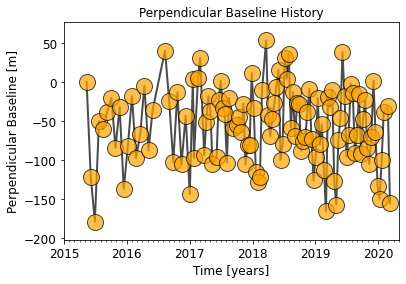

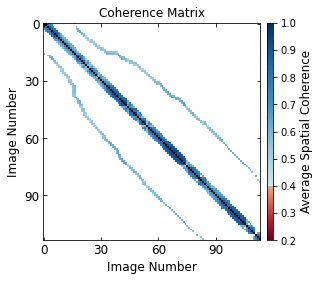

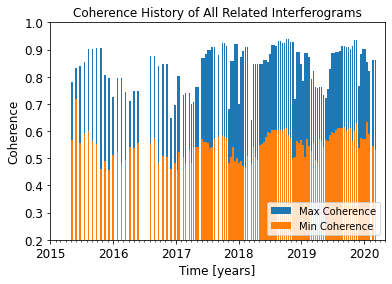

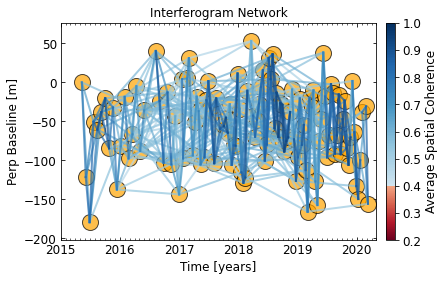

In [8]:
plot_network.main(['inputs/ifgramStack.h5'])

Note that with the `--nodisplay` argument, the plots won't be displayed but saved as pdf files in the current directory. Running this command creates multiple files as follows:

+ coherence_spatialAvg.txt: A simple text file that provides an overview to the stack and contains the interferogram dates, average coherence temporal and spatial baseline separation.
+ network.pdf: Displays the network of interferograms on time-baseline coordinates, colorcoded by avergae coherence of the interferograms. Circles represent the acquisition dates and lines represent the interferograms. Solid lines are the interferograms used for time-series analysis and dashed line are the interferograms ignored in the time-series analysis. 
+ coherenceMatrix.pdf shows the avergae coherence pairs between all available pairs in the stack.

## Generate masks before runing time-series

Before running the time-series inversion, one may want to looks at average coherence in the stack. To create a map of average spatial coherence use `temporal_average.py`:

setenv: Variable name must contain alphanumeric characters.
output file: avgSpatialCoh.h5
calculate the temporal average of coherence in file ./inputs/ifgramStack.h5 ...
[==================================================] lines 1021/1021   4s /     1s 
create HDF5 file: avgSpatialCoh.h5 with w mode
create dataset /coherence of float32    in size of (1021, 1021)         with compression=None
finished writing to avgSpatialCoh.h5
time used: 00 mins 7.4 secs

run view.py in MintPy release version v1.2.3-92, release date 2020-11-27
input file is coherence file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/avgSpatialCoh.h5 in float32 format
file size in y/x: (1021, 1021)
num of datasets in file avgSpatialCoh.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['coherence']
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833

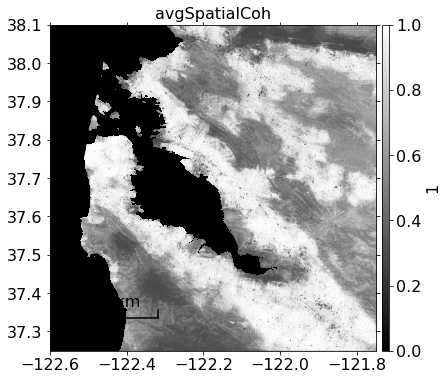

In [9]:
!temporal_average.py ./inputs/ifgramStack.h5 -d coherence -o avgSpatialCoh.h5
view.main(['avgSpatialCoh.h5'])

Also one may optionally extract the water mask from the geometry file to be used later for masking the time-series results:

setenv: Variable name must contain alphanumeric characters.
input geometry file: inputs/geometryGeo.h5
read inputs/geometryGeo.h5 waterMask
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with zero value
create HDF5 file: waterMask.h5 with w mode
create dataset /mask of bool       in size of (1021, 1021)         with compression=None
finished writing to waterMask.h5
time used: 00 mins 0.1 secs.


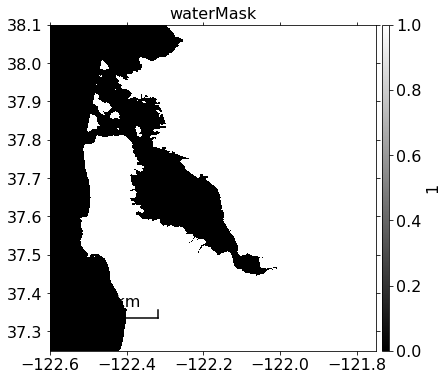

In [10]:
!generate_mask.py inputs/geometryGeo.h5 waterMask --nonzero -o waterMask.h5
view.main('waterMask.h5 -c gray --noverbose'.split())

setenv: Variable name must contain alphanumeric characters.
input ifgramStack file: inputs/ifgramStack.h5
--------------------------------------------------
update mode: ON
1) output file maskConnComp.h5 NOT exist.
run or skip: run.
calculate the common mask of pixels with non-zero connectComponent value
[==================================================] 505/505   14s /     0s
create HDF5 file: maskConnComp.h5 with w mode
create dataset /mask of bool       in size of (1021, 1021)         with compression=None
finished writing to maskConnComp.h5


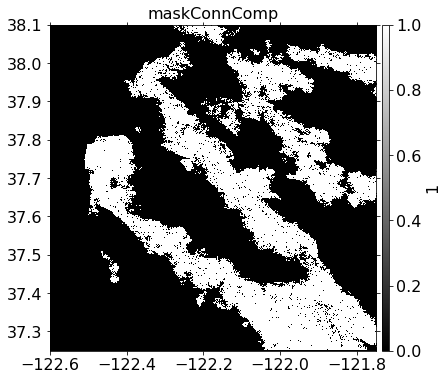

In [11]:
!generate_mask.py  inputs/ifgramStack.h5  --nonzero  -o maskConnComp.h5  --update
view.main('maskConnComp.h5 -c gray --noverbose'.split())

## reference_point

The interferometric phase is relative observation by nature. The phases of each unwrapped interferogram are relative with respect to an arbitrary pixel. Therfore we need to reference all interferograms to a common reference pixel.
The step "reference_point" selects a common reference pixel for the stack of interferograms. The default approach of mintpy is to choose a pixel with highest spatial coherence in the stack. Other options include specifying the longitude and latitude of the desired reference pixel or the line and column number of the refence pixel.    

In [12]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep reference_point

setenv: Variable name must contain alphanumeric characters.
MintPy release version v1.2.3-92, release date 2020-11-27
--RUN-at-2020-11-27 17:55:47.447050--
Current directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
read custom template file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/data/test/SanFranSenDT42/mintpy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs directory for backup.
copy

Running the "reference_step" adds additional attributes "REF_X, REF_Y" and "REF_LON, REF_LAT" to the ifgramStack.h5 file. To see the attributes of the file run info.py:

In [13]:
!info.py inputs/ifgramStack.h5 | egrep 'REF_'

setenv: Variable name must contain alphanumeric characters.
  REF_LAT                                         37.6895834975
  REF_LON                                         -122.0695835455
  REF_X                                           637
  REF_Y                                           492


Note that reference_point does not change the actual values of the unwrapped phase dataset. However, MintPy takes into account the phase at the reference point while performing the time-series inversion. 

## invert_network

In the next step we invert the network of differential unwrapped interferograms to estimate the time-series of unwrapped phase with respect to a reference acquisition date, which by default is the first acquisition. The estimated time-series is converted to distance change from radar to target and is provided in meters.  

In [14]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep invert_network

setenv: Variable name must contain alphanumeric characters.
MintPy release version v1.2.3-92, release date 2020-11-27
--RUN-at-2020-11-27 17:56:05.778831--
Current directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
read custom template file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/data/test/SanFranSenDT42/mintpy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs directory for backup.
copy smallbaselineApp.cfg to pic directory for backup.
read defau

The main product generated after running inver_network step, is timeseries.h5. To see the general content of the file run info.py

In [15]:
!info.py timeseries.h5 --compact

setenv: Variable name must contain alphanumeric characters.
******************** Basic File Info ************************
file name: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/timeseries.h5
file type: timeseries
coordinates : GEO

******************** Date Stat Info *************************
Start Date: 20150512
End   Date: 20200310
Number of acquisitions    : 114
Std. of acquisition times : 1.32 yeras
----------------------
List of dates:
['20150512', '20150605', '20150629', '20150723', '20150816', '20150909', '20151003', '20151027', '20151120', '20151214', '20160107', '20160131', '20160224', '20160319', '20160412', '20160506', '20160530', '20160810', '20160903', '20160927', '20161021', '20161114', '20161208', '20170101', '20170119', '20170125', '20170218', '20170302', '20170326', '20170407', '20170419', '20170501', '20170513', '20170606', '20170618', '20170630', '20170712', '20170724', '20170805', '20170817', '20170910', '20171004', '20171016', '20171028', '20171109', '20171121',

The timeseries file contains three datasets, the time-series which is the interferometric range change for each acquisition relative to the reference acquisition, the "date" dataset which contains the acquisition date for each acquisition and the bperp dataset which contains the timeseries of the perpendicular baseline.  

run view.py in MintPy release version v1.2.3-92, release date 2020-11-27
input file is timeseries file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/timeseries.h5 in float32 format
file size in y/x: (1021, 1021)
num of datasets in file timeseries.h5: 114
datasets to exclude (0):
[]
datasets to display (114):
['timeseries-20150512', 'timeseries-20150605', 'timeseries-20150629', 'timeseries-20150723', 'timeseries-20150816', 'timeseries-20150909', 'timeseries-20151003', 'timeseries-20151027', 'timeseries-20151120', 'timeseries-20151214', 'timeseries-20160107', 'timeseries-20160131', 'timeseries-20160224', 'timeseries-20160319', 'timeseries-20160412', 'timeseries-20160506', 'timeseries-20160530', 'timeseries-20160810', 'timeseries-20160903', 'timeseries-20160927', 'timeseries-20161021', 'timeseries-20161114', 'timeseries-20161208', 'timeseries-20170101', 'timeseries-20170119', 'timeseries-20170125', 'timeseries-20170218', 'timeseries-20170302', 'timeseries-20170326', 'timeseries-20170407

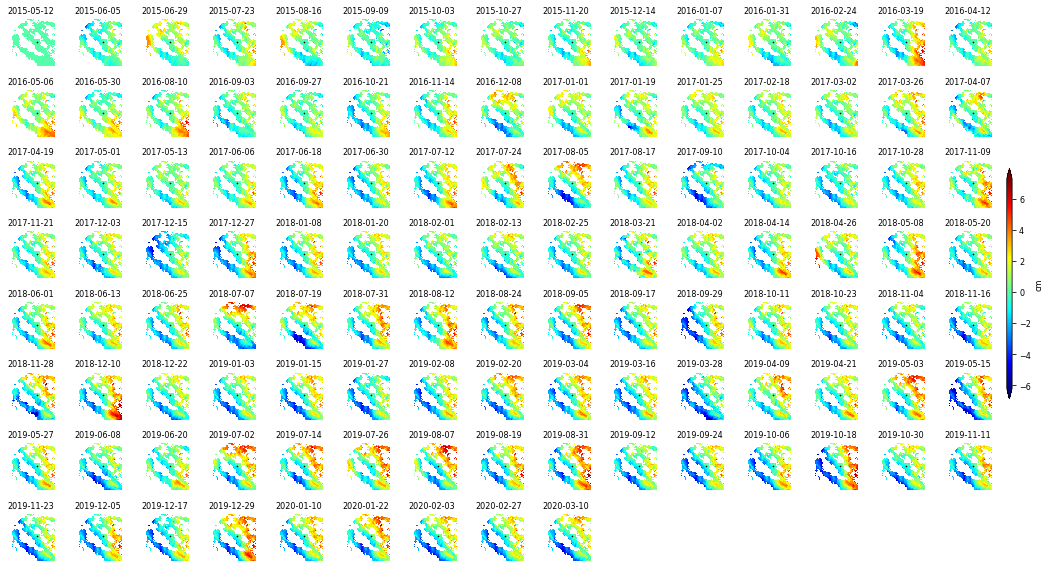

In [16]:
# for complex options
scp_args = 'timeseries.h5 -v -5 5 --noaxis '
view.main(scp_args.split())
# for all-default or no options in one-line : view.main(['timeseries.h5'])

<div class="alert alert-info">
<b>Question :</b> 
Why we invert a network of small baseline interferograms to estimate a single reference time-series, instead of forming the single-reference network of interferograms at first place? 
</div>

## velocity

The ground deformation caused by many geophysical or anthropogenic processes are linear at first order approximation. Therefore it is common to estimate the rate of the ground deformation which is the slope of linear fit to the time-series. The step "velocity" estimates the rate of the displacement. 

In [17]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep velocity

setenv: Variable name must contain alphanumeric characters.
MintPy release version v1.2.3-92, release date 2020-11-27
--RUN-at-2020-11-27 18:00:04.018511--
Current directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
read custom template file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/data/test/SanFranSenDT42/mintpy/smallbaselineApp.cfg
copy smallbaselineApp.cfg to inputs directory for backup.
copy smallbaselineApp.cfg to pic directory for backup.
read default template file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/smallbaselineApp.cfg


******************** step - veloci

run view.py in MintPy release version v1.2.3-92, release date 2020-11-27
input file is velocity file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/velocity.h5 in float32 format
file size in y/x: (1021, 1021)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [7.50, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [-1.4076, 1.1951466] cm/year
display range: [-1.0, 1.0] cm/year
display data in transparency: 1.0
plot in Lat/Lon coordinate
map projecti

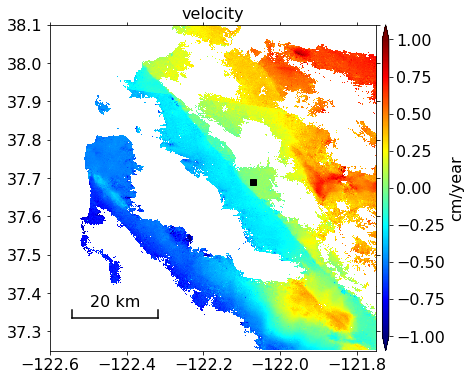

In [18]:
scp_args = 'velocity.h5 velocity -v -1 1'
view.main(scp_args.split())

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., Subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation).
</div>

Obvious features in the estimated velocity map:

1) The general pattern of displacement is consistent with tectonic setting of the region. Pacific plate is moving north-west with respect to North american plate. The satellites is on a descending track and the estimated displacement shows the blue region is moving away from the red region. 

2) The magnitude of the relative movement (blue region relative to red region) is about ~15 mm/yr in radar Line-Of-Sight (LOS) direction which is consistent with ~40 mm/yr horizontal movements of pacific relative to north america.

3) The estimated velocity shows a linear feature almost aligned with the south-east north-west diagonal of the map. This linear feature shows the aseismic fault creep on Hayward fault. 

4) Further north and around latitude 38N another linear feature represents Concord fault parallel to Hayward fault.

5) Around latitude 37.9 N, a east-west linear discontinuity is evident. This is most likely caused by missing bursts in some interferograms. 

6) The red region at the south-east corenr (around 37.35 N, 121.9W) seems to be a hydrological signal showing ground uplift caused by acquifer recharge.

7) The block box at 37.7N, 122.3W is the reference pixel for this map. 

<div class="alert alert-info">
<b>Note:</b> 
For an interactive plot of tinme-series for each pixel, use the tsview.ipynb jupyter notebook. From a terminal one may directly call the tsview.py to display InSAR time-series. 
</div>

The estimated velocity also comes with an expression of unecrtainty which is simply based on the goodness of fit while fitting a linear model to the time-series. This quantity is saved in "velocity.h5" under the velocityStd dataset. 

run view.py in MintPy release version v1.2.3-92, release date 2020-11-27
input file is velocity file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/velocity.h5 in float32 format
file size in y/x: (1021, 1021)
input dataset: "['velocityStd']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocityStd']
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [7.50, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [0.0, 0.13705222] cm/year
display range: [0.0, 0.2] cm/year
display data in transparency: 1.0
plot in Lat/Lon coordinate
map projec

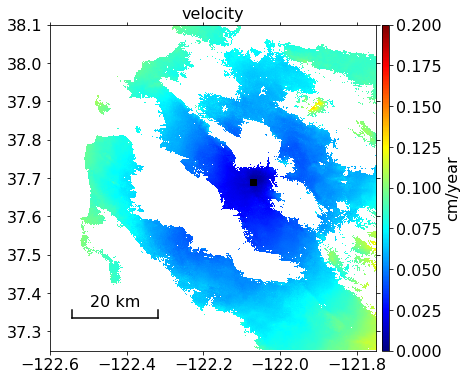

In [19]:
scp_args = 'velocity.h5 velocityStd -v 0 0.2'
view.main(scp_args.split())

The estimated standard deviation only represents the goodness of fit and can be biased or maybe under-estimating the actual uncertainty of the product. However, the spatial pattern of the estimated standard deviation is interesting and clearly shows the spatial correltion of noise in the time-series. The uncertainty is distance dependent and increases with increasing distance between pixels. This map shows the uncertainty for each pixle relative to the reference pixel. 

<div class="alert alert-info">
<b>Question :</b> 
What are the sources of errors that can potentially increase the uncertainty or bias the estimated velocity at this stage?  
</div>

# 3. Error analysis (what is signal, what is noise!)

Uncertainty of the ground displacement products derived from InSAR time-series, depends on the quality of the inversion of the stack of interferograms and the accuracy in separating the ground displacement from other components of the InSAR data. Therefore the definition of signal vs noise is different at the two main steps in mintpy:  

1) During the inversion: 
    At this step all systematic components of the interferometric phase (e.g., ground displacement, propagation delay, geometrical residuals caused by DEM or platform's orbit inaccuracy) are considered signal, while the interferometric phase decorrelation, phase unwrapping error and phase inconsistency are considered noise. 
    
2) After inversion: the ground displacement component of the time-serieses is signal, and everything else (including the propagation delay and geometrical residuals) are considered noise

Therefore we first discuss the possible sources of error during the inversion and the existing ways in MintPy to evaluate the quality of inversion and to improve the uncertainty of the inversion. Afterwards we explain the different components of the time-series and the different processing steps in MintPy to separate them from ground displacement signal.  


## 3.1 Quality of the inversion

The main sources of noise during the time-series inversion includes decorrelation, phase unwrapping error and the inconsistency of triplets of interferofgrams. Here we mainly focus on the decorrelation and unwrapping errors. We first show the existing quantities in MintPy to evaluate decorrelation and unwrapping errors and then discuss the existing ways in MintPy to reduce the decorrelation and unwrapping errors on the time-series inversion.

### 3.1.1 Average spatial coherence

Mintpy computes temporal average of spatial coherence of the entire stack as a potential ancillary measure to choose reliable pixels after time-series inversion. 

run view.py in MintPy release version v1.2.3-92, release date 2020-11-27
input file is coherence file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/avgSpatialCoh.h5 in float32 format
file size in y/x: (1021, 1021)
num of datasets in file avgSpatialCoh.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['coherence']
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
------------------------------------------------------------------------
colormap: gray
figure title: avgSpatialCoh
figure size : [7.50, 6.00]
reading data ...
data    range: [0.0, 0.9947392] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in Lat/Lon coordinate
map projection: PlateCarree
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
showing ...


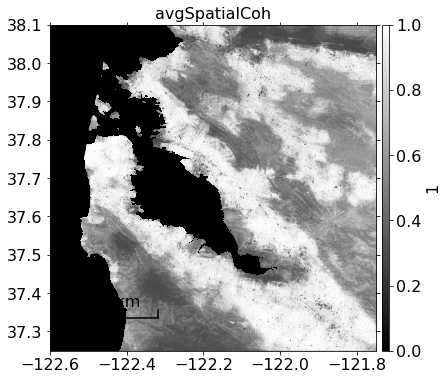

In [20]:
view.main(['avgSpatialCoh.h5'])

### 3.1.2 Temporal coherence

In addition to timeseries.h5 which contains the time-series dataset, invert_network produces other quantities, which contain metrics to evaluate the quality of the inversion including temporalCoherence.h5. Temporal coherence represents the consistency of the timeseries with the network of interferograms. 

Temporal coherence varies from 0 to 1. Pixels with values closer to 1 are considered reliable and pixels with values closer to zero are considered unreliable. For a dense network of interferograms, a threshold of 0.7 may be used (Yunjun et al, 2019).

run view.py in MintPy release version v1.2.3-92, release date 2020-11-27
input file is temporalCoherence file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/temporalCoherence.h5 in float32 format
file size in y/x: (1021, 1021)
num of datasets in file temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['temporalCoherence']
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
------------------------------------------------------------------------
colormap: gray
figure title: temporalCoherence
figure size : [7.50, 6.00]
reading data ...
data    range: [0.0, 1.0] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in Lat/Lon coordinate
map projection: PlateCarree
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point
showing ..

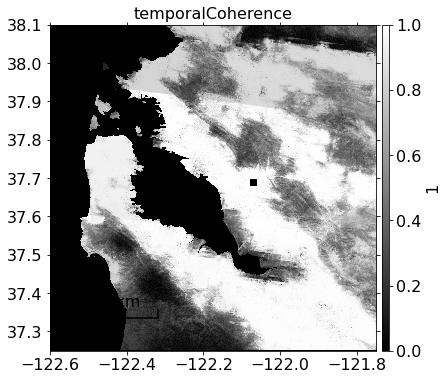

In [22]:
view.main(['temporalCoherence.h5','-c','gray'])

<div class="alert alert-info">
<b>Question :</b> 
For a network of interferograms with only one interferogram between each acquisition and subsequent acquisition (sequential network of interferograms), how the temporal coherence looks like? Can the temporal coherence be trusted in this case?
</div>

<div class="alert alert-info">
<b>Question :</b> 
Generally, the temporal coherence may resamble the spatial pattern of the average spatial coherence. Under what condition, an area with very high average spatial coherence may show very low temporal coherence?  
</div>

### 3.1.3 Phase unwrapping error detection

The interferometric phases are wrapped (modulo 2$\pi$) and integration of the wrapped phase, commonly called phase unwrapping, is required to obtain a field of relative phase with respect to a given pixel. The phase unwrapping algorithms add integer number of 2$\pi$ phase jumps to recover the unwrapped phase. Interferometric phase noise and discontinuities among different coherent regions may lead to wrong 2$\pi$ jumps added to the phase field known as unwrapping error. Unwrapping errors can bias the estimated time-series. 

For an interferogram triplet ($\Delta\phi^{ij}$, $\Delta\phi^{jk}$ and $\Delta\phi^{ik}$), unwrapping errors will introduce an non-zero integer component $C_{int}^{ijk}$ in the closure phase $C^{ijk}$. Therefore, the number of interferogram triplets with non-zero integer ambiguity $T_{int}$ can be used to detect unwrapping errors:

$$C^{ijk}=\Delta\phi^{ij}+\Delta\phi^{jk}-\Delta\phi^{ik}$$
$$C_{int}^{ijk}=\frac{C^{ijk}-wrap(C^{ijk})}{2\pi}$$
$$T_{int}=\sum_{i=1}^T(C_{int}^{ijk}!=0)$$

where $warp$ is an operator to wrap the input number into $[-\pi, \pi)$; $T$ is the number of interferogram triplets.

setenv: Variable name must contain alphanumeric characters.
update mode: ON
1) output file "./numTriNonzeroIntAmbiguity.h5" already exists
2) output file is newer than input dataset
3) all key configurations are the same: ['REF_Y', 'REF_X']
run or skip: skip.
time used: 00 mins 0.0 secs
Done.
plot and save figure to file numTriNonzeroIntAmbiguity.png


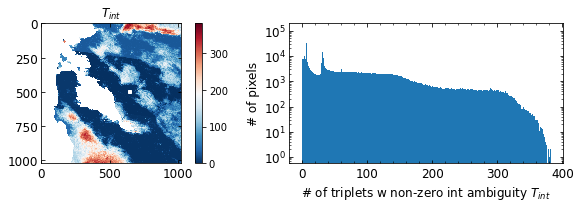

In [24]:
!unwrap_error_phase_closure.py  ./inputs/ifgramStack.h5  --action calculate  --water-mask waterMask.h5 --update
plot_num_triplet_with_nonzero_integer_ambiguity('numTriNonzeroIntAmbiguity.h5', display=True)

### 3.1.4 Modify the Network of interferograms

This step enables modifying the network of interferograms before the network inversion. Several options exist to modify a network. The network modification can be based on choosing interferogram based on an average coherence value over the entire interferogram (optionally masked area), or over an area of interest. The network can be also modified based on temporal and perpendicular baseline thresholds, maximum number of connections between each acquisition and following acquisitions, or simply by excluding dates or interferogram pairs or their indices. All different network modification options can be configured through the configuration file:

```cfg
## 1) Coherence-based network modification = Threshold + MST, by default
## It calculates a average coherence value for each interferogram using spatial coherence and input mask (with AOI)
## Then it finds a minimum spanning tree (MST) network with inverse of average coherence as weight (keepMinSpanTree)
## For all interferograms except for MST's, exclude those with average coherence < minCoherence.
mintpy.network.coherenceBased  = auto  #[yes / no], auto for no, exclude interferograms with coherence < minCoherence
mintpy.network.keepMinSpanTree = auto  #[yes / no], auto for yes, keep interferograms in Min Span Tree network
mintpy.network.minCoherence    = auto  #[0.0-1.0], auto for 0.7
mintpy.network.maskFile        = auto  #[file name, no], auto for waterMask.h5 or no (use all pixels)
mintpy.network.aoiYX           = auto  #[y0:y1,x0:x1 / no], auto for no, area of interest for coherence calculation
mintpy.network.aoiLALO         = auto  #[lat0:lat1,lon0:lon1 / no], auto for no - use the whole area

## 2) Network modification based on temporal/perpendicular baselines, date etc.
mintpy.network.tempBaseMax     = auto  #[1-inf, no], auto for no, maximum temporal baseline in days
mintpy.network.perpBaseMax     = auto  #[1-inf, no], auto for no, maximum perpendicular spatial baseline in meter
mintpy.network.connNumMax      = auto  #[1-inf, no], auto for no, maximum number of neighbors for each acquisition
mintpy.network.referenceFile   = auto  #[date12_list.txt / ifgramStack.h5 / no], auto for no
mintpy.network.excludeDate     = 20160107  #[20080520,20090817 / no], auto for no
mintpy.network.excludeIfgIndex = auto  #[1:5,25 / no], auto for no, list of ifg index (start from 0)
mintpy.network.startDate       = auto  #[20090101 / no], auto for no
mintpy.network.endDate         = auto  #[20110101 / no], auto for no
```

<div class="alert alert-info">
<b>TIP:</b> 
For coherence-based network modification, a customized area of interest (AOI) that includes the low coherence pixels surrounding is recommended. 
</div>


<div class="alert alert-info">
<b>TIP:</b> 
For best results, we recommend (if possible) users process a redundant network of interferograms to have more freedom to modify the network before the inversion. 
</div>

By looking at the temporal coherence we suspect that some of the interferograms may have missing frames or may have wrong stitching. Since we have many interefrograms, we have the flexibility to remove few if possible. Let's first plot all interferograms and visually investigate any problem with some pairs. 

run view.py in MintPy release version v1.2.3-92, release date 2020-11-27
input file is ifgramStack file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/inputs/ifgramStack.h5 in float32 format
file size in y/x: (1021, 1021)
num of datasets in file ifgramStack.h5: 1515
num of datasets to exclude: 0
num of datasets to display: 505
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
------------------------------------------------------------------------
colormap: jet
figure title: unwrapPhase
figure size : [15.00, 8.00]
dataset number: 505
row     number: 8
column  number: 16
figure  number: 4
number of data points per figures: 1.3E+08
multilook with a factor of 4 for display
consider reference pixel in y/x: [492, 637]
mark interferograms with 'dropIfgram=False' in red colored title
---

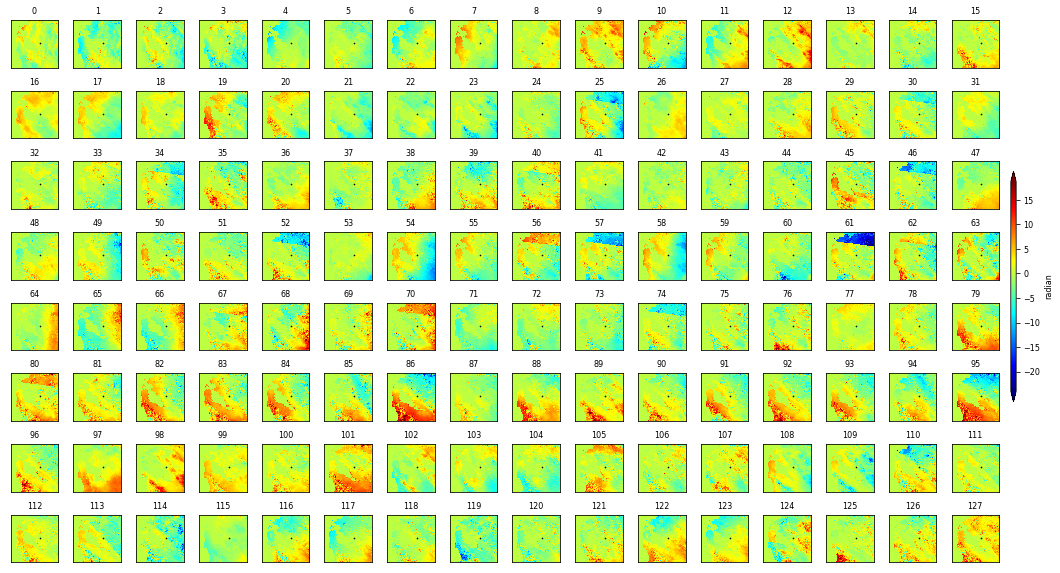

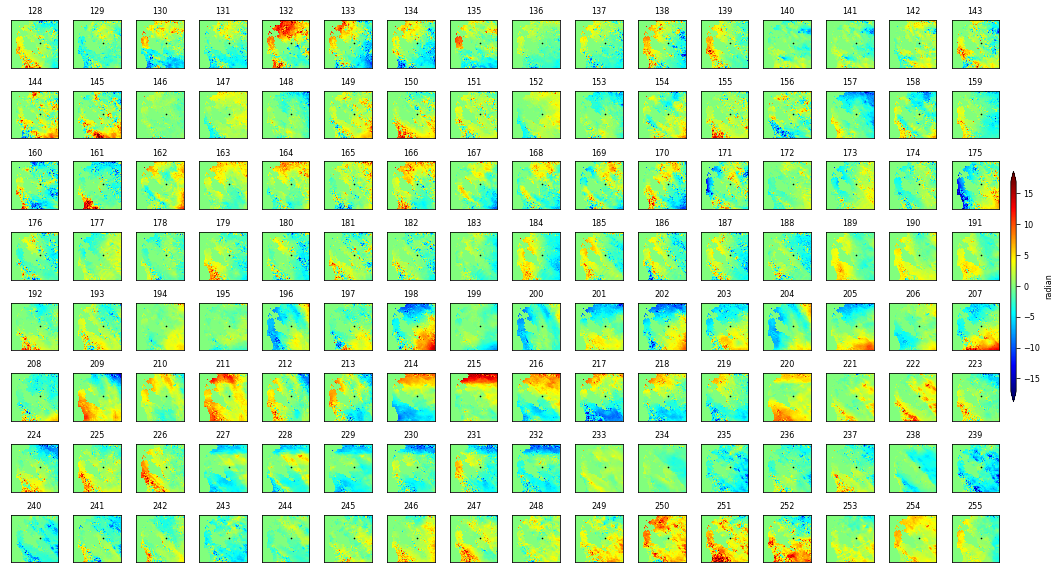

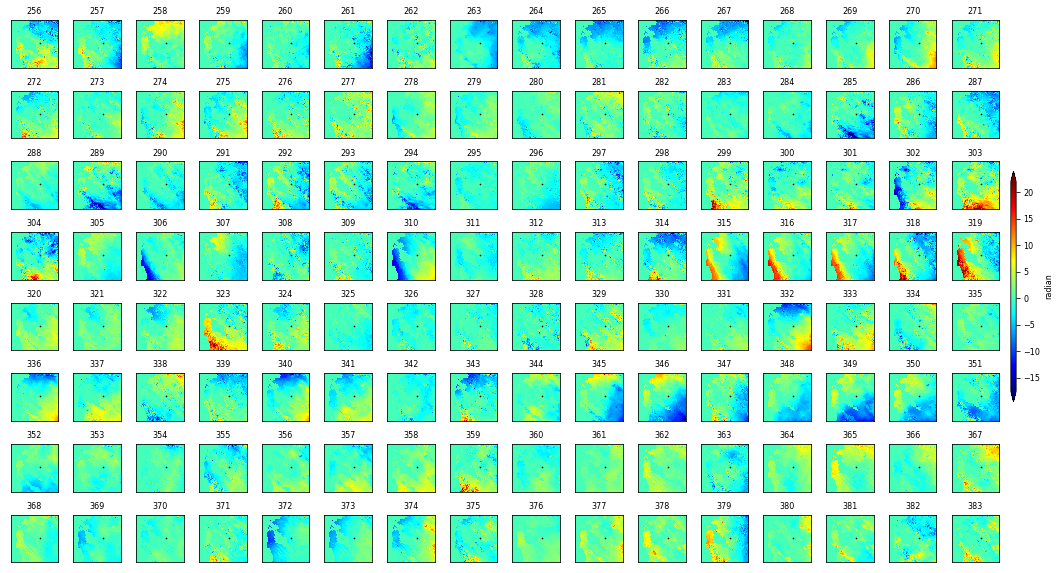

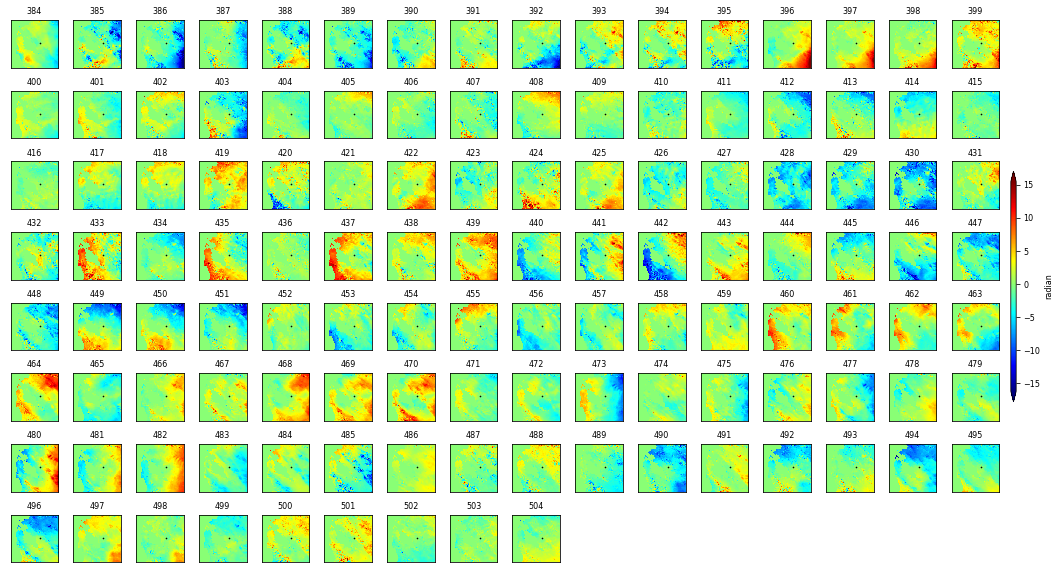

In [25]:
scp_args = 'inputs/ifgramStack.h5 -v -10 10'
view.main(scp_args.split())

By investigating all the interferograms it's obvious that the interferograms with the following indices have clear jumps at a burst boundary most likely caused by missing bursts in some acquisitions or due to problems in stitching:

25, 30, 34, 40, 46, 52, 56, 57, 61, 62, 67, 70, 74, 80

Therfore we decide to remove these interferograms from the stack and repeat the inversion. To remove the interferograms with specific indices we need to exclude the following option in the configuration file



```cfg
mintpy.network.excludeIfgIndex = 25, 30, 34, 40, 46, 52, 56, 57, 61, 62, 67, 70, 74, 80
mintpy.network.keepMinSpanTree = yes
```

In [28]:
additional_config = """mintpy.network.excludeIfgIndex = 25, 30, 34, 40, 46, 52, 56, 57, 61, 62, 67, 70, 74, 80
mintpy.network.keepMinSpanTree = yes"""
configure_template_file(configName, additional_config)

write configuration to file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt


<div class="alert alert-info">
<b>NOTE:</b> 
By modifying the network, the interferograms are not physically removed. However the value for that interferogram in the dropIfgram dataset in ifgramStack.h5 turns to False.  
</div>

<div class="alert alert-info">
<b>NOTE:</b> 
By forcing the mintpy.network.keepMinSpanTree = yes option, the connectivity of the network is always gauranteed.
</div>

In [29]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep modify_network

setenv: Variable name must contain alphanumeric characters.
MintPy release version v1.2.3-92, release date 2020-11-27
--RUN-at-2020-11-27 18:06:04.824678--
Current directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
read custom template file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt
update default template based on input custom template
    mintpy.network.keepMinSpanTree: auto --> yes
    mintpy.network.excludeIfgIndex: auto --> 25, 30, 34, 40, 46, 52, 56, 57, 61, 62, 67, 70, 74, 80
copy

Plotting the network after network modification shows how the network looks like

read temporal/spatial baseline info from file: inputs/ifgramStack.h5
calculating spatial mean of coherence in file inputs/ifgramStack.h5 ...
read mask from file: waterMask.h5
[==================================================] 505/505   33s /     0s 
write average value in space into text file: coherenceSpatialAvg.txt
number of acquisitions: 114
number of interferograms: 505
--------------------------------------------------
number of interferograms marked as drop: 14
number of interferograms marked as keep: 491
number of acquisitions marked as drop: 0
max coherence of excluded interferograms: 0.569473147392273
max perpendicular baseline: 219.65 m
max temporal      baseline: 456.0 days
showing coherence
data range: [0.4563738, 0.939412]
display range: (0.2, 1.0)
showing ...


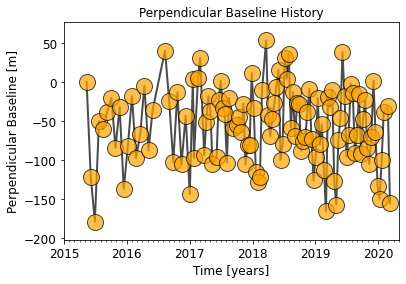

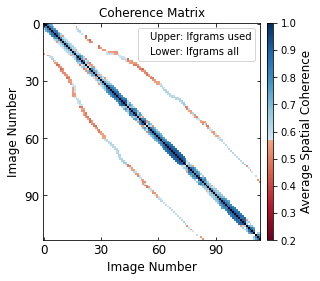

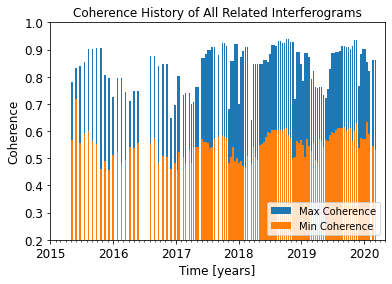

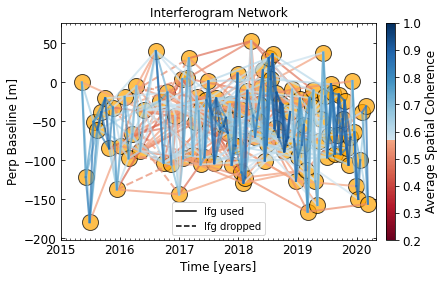

In [30]:
plot_network.main(['inputs/ifgramStack.h5'])

After modifying the network, we need to manually remove the timeseries and re-run the inversion to see the impact of the network modification

In [31]:
!rm timeseries.h5
!smallbaselineApp.py SanFranSenDT42.txt --dostep invert_network

setenv: Variable name must contain alphanumeric characters.
/Users/yunjunz/tools/UTILITIES/shell-safe-rm/bin/rm.sh: Command not found.
setenv: Variable name must contain alphanumeric characters.
MintPy release version v1.2.3-92, release date 2020-11-27
--RUN-at-2020-11-27 18:07:10.630815--
Current directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
read custom template file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/data/test/SanFranSenDT42/mintpy/smallbase

Let's check how the temporal coherence looks like after removing those interferograms. 

run view.py in MintPy release version v1.2.3-92, release date 2020-11-27
input file is temporalCoherence file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/temporalCoherence.h5 in float32 format
file size in y/x: (1021, 1021)
num of datasets in file temporalCoherence.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['temporalCoherence']
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
------------------------------------------------------------------------
colormap: gray
figure title: temporalCoherence
figure size : [7.50, 6.00]
reading data ...
data    range: [0.0, 1.0] 1
display range: [0.0, 1.0] 1
display data in transparency: 1.0
plot in Lat/Lon coordinate
map projection: PlateCarree
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point
showing ..

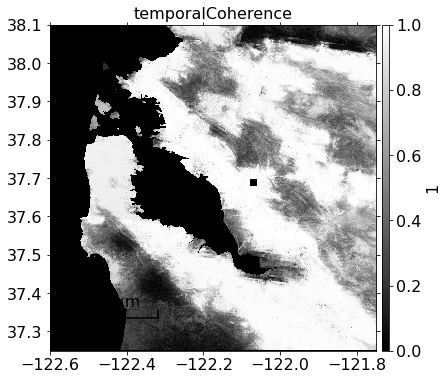

In [33]:
view.main(['temporalCoherence.h5','-c','gray'])

Note that the temporal coherence at the top has increased and the discontinuity has disapeared.

<div class="alert alert-info">
<b>Question:</b> 
If someone is interested only in the timeseries at one of the islands arround latitude 37.9N, where the reference pixel should be put in?</div>

### 3.1.5 Phase unwrapping error correction

MintPy provides three methods to possibly detect and correct the phase unwrapping errors. The first method is based on the phase closure of the triplets of the interferograms. The second methods is automating the traditional manual bridging method in which coherent components with the smallest distance from each other are assumed connected and therefore the a smooth phase variation across them are enforced. The third approach is a hybrid approach and simply uses the both approached mentioned before.

Note that to use the phase closure approach a dense network of interferograms should be available.

To use the phase unwrapping error correction methods usually a common mask is generated, which shows pixels with valid unwrapped phase in all interferograms. 

The phase unwrapping error correction can be configured using the following options:

```cfg
## connected components (mintpy.load.connCompFile) are required for this step.
## reference: Yunjun et al. (2019, section 3)
## supported methods:
## a. phase_closure - suitable for highly redundant network
## b. bridging      - suitable for regions separated by narrow decorrelated features, e.g. rivers, narrow water bodies
## c. bridging+phase_closure
mintpy.unwrapError.method          = auto  #[bridging / phase_closure / bridging+phase_closure / no], auto for no
mintpy.unwrapError.waterMaskFile   = auto  #[waterMask.h5 / no], auto for waterMask.h5 or no [if not found]

## briding options:
## ramp - a phase ramp could be estimated based on the largest reliable region, removed from the entire interferogram
##        before estimating the phase difference between reliable regions and added back after the correction.
## bridgePtsRadius - half size of the window used to calculate the median value of phase difference
mintpy.unwrapError.ramp            = auto  #[linear / quadratic], auto for no; recommend linear for L-band data
mintpy.unwrapError.bridgePtsRadius = auto  #[1-inf], auto for 50, half size of the window around end points
```

### 3.1.6 Weighted least squares

The following **weighted least squares (WLS) inversions** methods are supported:

+ Inverse of covariance
+ Finisher Information Matrix (FIM)
+ Spatial coherence
+ Uniform / no weighting

The corresponding template options are: 

```cfg
## Invert network of interferograms into time-series using weighted least sqaure (WLS) estimator.
## weighting options for least square inversion [fast option available but not best]:
## a. var - use inverse of covariance as weight (Tough et al., 1995; Guarnieri & Tebaldini, 2008) [recommended]
## b. fim - use Fisher Information Matrix as weight (Seymour & Cumming, 1994; Samiei-Esfahany et al., 2016).
## c. coh - use coherence as weight (Perissin & Wang, 2012)
## d. no  - uniform weight (Berardino et al., 2002) [fast]
## SBAS (Berardino et al., 2002) = minNormVelocity (yes) + weightFunc (no)
mintpy.networkInversion.weightFunc      = auto #[var / fim / coh / no], auto for var
```

By default MintPy uses the same network of interferograms for all the pixels. However, it is possible to use variable networks for different pixels by specifying a mask dataset, a threshold value for the mask and a minimum redundance value: 
  
```cfg
## mask options for unwrapPhase of each interferogram before inversion (recommed if weightFunct=no):
## a. coherence        - mask out pixels with spatial coherence < maskThreshold
## b. connectComponent - mask out pixels with False/0 value
## c. no               - no masking [recommended].
## d. offsetSNR        - mask out pixels with offset SNR < maskThreshold [for offset]
mintpy.networkInversion.maskDataset   = auto #[coherence / connectComponent / offsetSNR / no], auto for no
mintpy.networkInversion.maskThreshold = auto #[0-inf], auto for 0.4
mintpy.networkInversion.minRedundancy = auto #[1-inf], auto for 1.0, min num_ifgram for every SAR acquisition
```

<div class="alert alert-info">
<b>NOTE:</b> 
If you choose to use variable network for different pixels, then interpret the temporal coherence with caution as the temporal coherence for a network with only obe connection between each acquisition and next acquisition is 1. A by product named numInvIfgram.h5 shows the number of interferograms used in the inversion for each pixel.
</div>

MintPy by default masks the estimated time-series using waterMask.h5. However, the mask can be specified or can be turned off:

```cfg
## Temporal coherence is calculated and used to generate the mask as the reliability measure
## reference: Pepe & Lanari (2006, IEEE-TGRS)
mintpy.networkInversion.minTempCoh  = auto #[0.0-1.0], auto for 0.7, min temporal coherence for mask
mintpy.networkInversion.minNumPixel = auto #[int > 1], auto for 100, min number of pixels in mask above
mintpy.networkInversion.shadowMask  = auto #[yes / no], auto for yes [if shadowMask is in geometry file] or no.
```

The least squares inversion can be performed using phase (A matrix in Berardino et al, 2002) or using phase velocity (B matrix in Berardino at al, 2002). The latter allows to invert a disconnected network. For a connected network, the design matrix is full-rank and the inversion using either methods are the same. The minimization is primarily based on L2 norm minimization. The L1 norm minimization has not been extensively tested. 

```cfg
mintpy.networkInversion.minNormVelocity = auto #[yes / no], auto for yes, min-norm deformation velocity or phase
mintpy.networkInversion.residualNorm    = auto #[L2 ], auto for L2, norm minimization solution
```

MintPy offers some options to use dask for parallel computing:

```cfg
mintpy.compute.memorySize  = auto #[float > 0.0], auto for 2, max memory to allocate in GB
## parallel processing with dask
## cluster   = no   to turn off the parallel computing
## numWorker = all  to use all locally available cores (for cluster = local only)
## config    = none to rollback to the default name (same as the cluster type; for cluster != local)
mintpy.compute.cluster     = auto #[local / slurm / pbs / lsf / no], auto for no, cluster type
mintpy.compute.numWorker   = auto #[int > 1 / all], auto for 4 (local) or 40 (non-local), num of workers
mintpy.compute.config      = auto #[none / slurm / pbs / lsf ], auto for none (same as cluster), config name
```

## 3.2 Noise reduction of InSAR displacement time-series

After inversion of the network of interferograms, the estimated time-series contains different components including tropospheric delay, topographic residuals ground displacement and other possible geophysical components (e.g., tide, ionosphere if they have not been corrected) or instrumental effects (e.g., the local oscilator drift of Envisat). Given ground displacement as our signal of interest, the following processing steps attempt to separate signal from noise and provide a ground displacement time-series for selected coherent pixels.

### 3.2.1 Correct local oscillator drift (for Envisat) 

Data from Envisat’s Advanced Synthetic Aperture Radar (ASAR) instrument include a phase ramp in range direction due to timing errors. This step corrects the local oscillator drift using the empirical model given by Marinkovic and Larsen (2013). It's automatically turned ON for Envisat data and OFF for all the other dataset.

### 3.2.2 Tropospheric delay correction

This step corrects the tropospheric phase delay. Two methods are supported:

+ Global Atmospheric Models (GAMs) (Jolivet et al., 2011; 2014; PyAPS needs to be installed).
+ Empirical relationship between stratified tropospheric delay and topography (Doin et al., 2009).

The corresponding template options are:

```cfg
## a. height_correlation - correct stratified tropospheric delay (Doin et al., 2009, J Applied Geop)
## b. pyaps - use Global Atmospheric Models (GAMs) data (Jolivet et al., 2011; 2014)
##      ERA5  - ERA-5       from ECMWF [need to install pyaps3 on GitHub; recommended and turn ON by default]
##      ECMWF - ERA-Interim from ECMWF [need to install pyaps  on Caltech/EarthDef]
##      MERRA - MERRA-2     from NASA  [need to install pyaps  on Caltech/EarthDef]
##      NARR  - NARR        from NOAA  [need to install pyaps  on Caltech/EarthDef; recommended for N America]
mintpy.troposphericDelay.method = auto  #[pyaps / height_correlation / no], auto for pyaps

## Notes for pyaps:
## a. GAM data latency: with the most recent SAR data, there will be GAM data missing, the correction
##    will be applied to dates with GAM data available and skipped for the others.
## b. WEATHER_DIR: if you define an environmental variable named WEATHER_DIR to contain the path to a
##    directory, then MintPy applications will download the GAM files into the indicated directory. 
##    MintPy application will look for the GAM files in the directory before downloading a new one to
##    prevent downloading multiple copies if you work with different dataset that cover the same date/time.
mintpy.troposphericDelay.weatherModel = auto  #[ERA5 / ECMWF / MERRA / NARR], auto for ERA5
mintpy.troposphericDelay.weatherDir   = auto  #[path2directory], auto for WEATHER_DIR or "./"

## Notes for height_correlation:
## Extra multilooking is applied to estimate the empirical phase/elevation ratio ONLY.
## For an dataset with 5 by 15 looks, looks=8 will generate phase with (5*8) by (15*8) looks
## to estimate the empirical parameter; then apply the correction to original phase (with 5 by 15 looks),
## if the phase/elevation correlation is larger than minCorrelation.
mintpy.troposphericDelay.polyOrder      = auto  #[1 / 2 / 3], auto for 1
mintpy.troposphericDelay.looks          = auto  #[1-inf], auto for 8, extra multilooking num
mintpy.troposphericDelay.minCorrelation = auto  #[0.0-1.0], auto for 0
```

It outputs:
+ timeseries_ERA5.h5: the troposphere-corrected time-series (ERA5 data is selected in this case).
+ inputs/ERA5.h5: the estimated tropospheric phase delay time-series (for pyaps method only).

### 3.2.3 deramping (optional)

This step estimate and removes a linear or quadratic ramp from each acquisition based on the phase of the reliable pixels. It's recommended for localized deformation signals, such as volcanic deformation, landslides and city subsidence; but not recommeded for long spatial wavelength deformation signals, such as interseismic deformation.

The cooresponding template options are:

```cfg
## Estimate and remove a phase ramp for each acquisition based on the reliable pixels.
## Recommended for localized deformation signals, i.e. volcanic deformation, landslide and land subsidence, etc.
## NOT recommended for long spatial wavelength deformation signals, i.e. co-, post- and inter-seimic deformation.
mintpy.deramp          = auto  #[no / linear / quadratic], auto for no - no ramp will be removed
mintpy.deramp.maskFile = auto  #[filename / no], auto for maskTempCoh.h5, mask file for ramp estimation
```

It outputs a new time-series HDF5 file with suffix _ramp_: timeseries_ERA5_ramp.h5 in this example.

### 3.2.4 Topographic residual correction

This step corrects the phase residual caused by the inaccuracy of DEM (DEM error) using its relationship with the perpendicular baseline time-series (Fattahi and Amelung, 2013, IEEE-TGRS). The corresponding template options are:

```cfg
## reference: Fattahi and Amelung (2013, IEEE-TGRS)
## stepFuncDate      - Specify stepFuncDate option if you know there are sudden displacement jump in your area,
##    i.e. volcanic eruption, or earthquake, and check timeseriesStepModel.h5 afterward for their estimation.
## excludeDate       - Dates excluded for error estimation only
## pixelwiseGeometry - Use pixel-wise geometry info, i.e. incidence angle and slant range distance
##    yes - use pixel-wise geometry when they are available [slow; used by default]
##    no  - use mean geometry [fast]
mintpy.topographicResidual                   = auto  #[yes / no], auto for yes
mintpy.topographicResidual.polyOrder         = auto  #[1-inf], auto for 2, poly order of temporal deformation model
mintpy.topographicResidual.phaseVelocity     = auto  #[yes / no], auto for no - phase, use phase velocity for minimization
mintpy.topographicResidual.stepFuncDate      = auto  #[20080529,20100611 / no], auto for no, date of step jump
mintpy.topographicResidual.excludeDate       = auto  #[20070321 / txtFile / no], auto for exclude_date.txt
mintpy.topographicResidual.pixelwiseGeometry = auto  #[yes / no], auto for yes, use pixel-wise geometry info
```

It outputs:
+ timeseries_ERA5_ramp_demErr.h5: the topographic residual corrected time-series.
+ timeseriesResidual.h5: residual phase time-series of this least square inversion.
+ demErr.h5: the estimated DEM error.

In [35]:
configure_template_file(configName, "mintpy.topographicResidual                    = yes")

write configuration to file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt


In [36]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep correct_topography

setenv: Variable name must contain alphanumeric characters.
MintPy release version v1.2.3-92, release date 2020-11-27
--RUN-at-2020-11-27 18:11:35.633759--
Current directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
read custom template file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt
update default template based on input custom template
    mintpy.topographicResidual: no --> yes
copy SanFranSenDT42.txt to inputs directory for backup.
copy smallbaselineApp.cfg to inputs directory for backup.
copy SanFranSenDT42.txt to pic directory for backup.
copy smallbaselineApp.cfg to pic directory for backup.
read default template file: /User

To view the estimated DEM error:

run view.py in MintPy release version v1.2.3-92, release date 2020-11-27
input file is dem file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/demErr.h5 in float32 format
file size in y/x: (1021, 1021)
num of datasets in file demErr.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['dem']
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
------------------------------------------------------------------------
colormap: jet
figure title: demErr
figure size : [7.50, 6.00]
reading data ...
data    range: [-43.7011, 61.44901] m
display range: [-43.7011, 61.44901] m
display data in transparency: 1.0
plot in Lat/Lon coordinate
map projection: PlateCarree
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point
showing ...


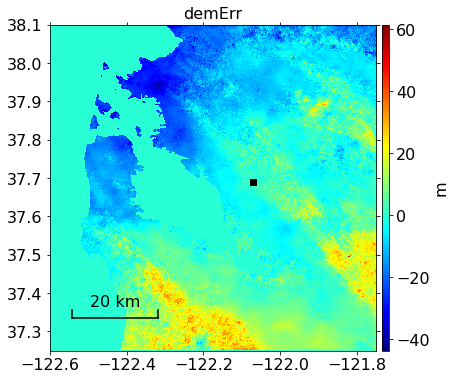

In [37]:
view.main(['demErr.h5'])

### 3.2.5 Residual RMS for noise evaluation

This step calculates the Root Mean Square (RMS) of the residual phase time-series for each acquisition; then it:
1. selects the date with the minimum RMS value as the optimal reference date.
2. detects the noisy acquisitions with RMS beyond the outlier detection threshold.

The corresponding template options are:
```cfg
## 1) Residual Phase Root Mean Square
## calculate the Root Mean Square (RMS) of residual phase time-series for each acquisition
## To get rid of long wavelength component in space, a ramp is removed for each acquisition
## Set optimal reference date to date with min RMS
## Set exclude dates (outliers) to dates with RMS > cutoff * median RMS (Median Absolute Deviation)
mintpy.residualRMS.maskFile = auto  #[file name / no], auto for maskTempCoh.h5, mask for ramp estimation
mintpy.residualRMS.deramp   = auto  #[quadratic / linear / no], auto for quadratic
mintpy.residualRMS.cutoff   = auto  #[0.0-inf], auto for 3
```

It outputs:
+ rms_timeseriesResidual_ramp.txt: for RMS value of each acquisition
+ rms_timeseriesResidual_ramp.pdf: plot of the rms_timeseriesResidual_ramp.txt
+ reference_date.txt: date in YYYYMMDD format for the optional reference date
+ exclude_date.txt: date(s) in YYYYMMDD format for the noisy acquisitions (if at least one is detected).

In [38]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep residual_RMS

setenv: Variable name must contain alphanumeric characters.
MintPy release version v1.2.3-92, release date 2020-11-27
--RUN-at-2020-11-27 18:12:31.220383--
Current directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
Run routine processing with smallbaselineApp.py on steps: ['residual_RMS']
Remaining steps: ['reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
read custom template file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/data/test/SanFranSenDT42/mintpy/smallbaselineApp.cfg
copy SanFranSenDT42.txt to inputs directory for backup.
copy smallbaselineApp.cfg to inputs directory for backup.
copy SanFranSenDT42.txt to pic directory for backup.
copy smallbaselineApp.cfg to pic directory f

In [39]:
cat rms_timeseriesResidual_ramp.txt

setenv: Variable name must contain alphanumeric characters.
# Root Mean Square in space for each acquisition of time-series
# Timeseries file: timeseriesResidual_ramp.h5
# Mask file: maskTempCoh.h5
# Date		RMS (m)
20150512	0.006070085801184177
20150605	0.004277286119759083
20150629	0.004580835811793804
20150723	0.00442724721506238
20150816	0.004154605325311422
20150909	0.005963069386780262
20151003	0.0029967029113322496
20151027	0.003727300325408578
20151120	0.004250113852322102
20151214	0.003609269391745329
20160107	0.00247786333784461
20160131	0.003067201003432274
20160224	0.005392164923250675
20160319	0.0032999087125062943
20160412	0.0030201917979866266
20160506	0.003916292916983366
20160530	0.004869081079959869
20160810	0.005371026694774628
20160903	0.005789398215711117
20160927	0.004434312228113413
20161021	0.0035867500118911266
20161114	0.003713237587362528
20161208	0.004568515811115503
20170101	0.002667972119525075
20170119	0.006859052926301956
20170125	0.0033397639635950327
201

In [40]:
cat reference_date.txt

setenv: Variable name must contain alphanumeric characters.
20190527


### 3.2.6 Changing the reference date

This step changes the reference date of all phase time-series files, based on the input template option:

```cfg
## reference all time-series to one date in time
## no     - do not change the default reference date (1st date)
mintpy.reference.date  = auto   #[reference_date.txt / 20090214 / no], auto for reference_date.txt
```

This step operates on the existing time-series files and does not output new files.

<div class="alert alert-warning">
<b>Note:</b> 
The optimal reference date (default option) gives the time-series plot a "clean" looks only. Changing the reference is equivalent to adding a constant to the displacement time series, which does not change the velocity or any other information derived from the displacement time series.
</div>

In [41]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep reference_date

setenv: Variable name must contain alphanumeric characters.
MintPy release version v1.2.3-92, release date 2020-11-27
--RUN-at-2020-11-27 18:13:38.294850--
Current directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
Run routine processing with smallbaselineApp.py on steps: ['reference_date']
Remaining steps: ['velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
read custom template file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/data/test/SanFranSenDT42/mintpy/smallbaselineApp.cfg
copy SanFranSenDT42.txt to inputs directory for backup.
copy smallbaselineApp.cfg to inputs directory for backup.
copy SanFranSenDT42.txt to pic directory for backup.
copy smallbaselineApp.cfg to pic directory for backup.
read 

### 3.2.7 Re-estimating Velocity after noise reduction

This step estimates the slope of the best fitting line to the displacement time-series and its standard deviation. Noisy acquisitions (identified in "residual_RMS" step) from exclude_date.txt file are excluded by default during the estimation. 

The corresponding template options are:

```cfg
## Estimate linear velocity and its standard deviation from time-series
## and from tropospheric delay file if exists.
## reference: Fattahi and Amelung (2015, JGR)
mintpy.velocity.excludeDate    = auto   #[exclude_date.txt / 20080520,20090817 / no], auto for exclude_date.txt
mintpy.velocity.startDate      = auto   #[20070101 / no], auto for no
mintpy.velocity.endDate        = auto   #[20101230 / no], auto for no
```

It outputs:
+ velocity.h5: the estimated average velocity and its standard deviation from displacement time-series.
+ velocityERA5.h5: same as above but from the tropospheric delay time-series, to see the potential bias introduced by troposphere if it was not corrected.

In [42]:
!smallbaselineApp.py SanFranSenDT42.txt --dostep velocity
!smallbaselineApp.py SanFranSenDT42.txt --dostep google_earth

setenv: Variable name must contain alphanumeric characters.
MintPy release version v1.2.3-92, release date 2020-11-27
--RUN-at-2020-11-27 18:13:52.842604--
Current directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: SanFranSenDT42
Go to work directory: /Users/yunjunz/data/test/SanFranSenDT42/mintpy
read custom template file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/SanFranSenDT42.txt
update default template based on input custom template
No new option value found, skip updating /Users/yunjunz/data/test/SanFranSenDT42/mintpy/smallbaselineApp.cfg
copy SanFranSenDT42.txt to inputs directory for backup.
copy smallbaselineApp.cfg to inputs directory for backup.
copy SanFranSenDT42.txt to pic directory for backup.
copy smallbaselineApp.cfg to pic directory for backup.
read default template f

run view.py in MintPy release version v1.2.3-92, release date 2020-11-27
input file is velocity file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/velocity.h5 in float32 format
file size in y/x: (1021, 1021)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [7.50, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [-1.4619201, 1.1909944] cm/year
display range: [-1.0, 1.0] cm/year
display data in transparency: 1.0
plot in Lat/Lon coordinate
map proje

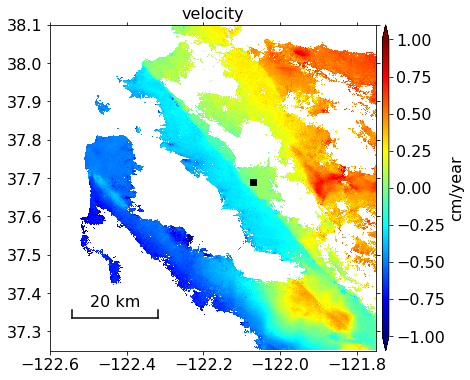

In [43]:
scp_args = 'velocity.h5 velocity -v -1 1'
view.main(scp_args.split())

view.py velocity.h5  velocity 
run view.py in MintPy release version v1.2.3-92, release date 2020-11-27
input file is velocity file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/velocity.h5 in float32 format
file size in y/x: (1021, 1021)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [7.50, 6.00]
read mask from file: maskTempCoh.h5
data    range: [-1.4619201, 1.1909944] cm/year
display range: [-1.4619201, 1.1909944] cm/year
display data in transparency: 1.0
plot in Lat/Lon coordin

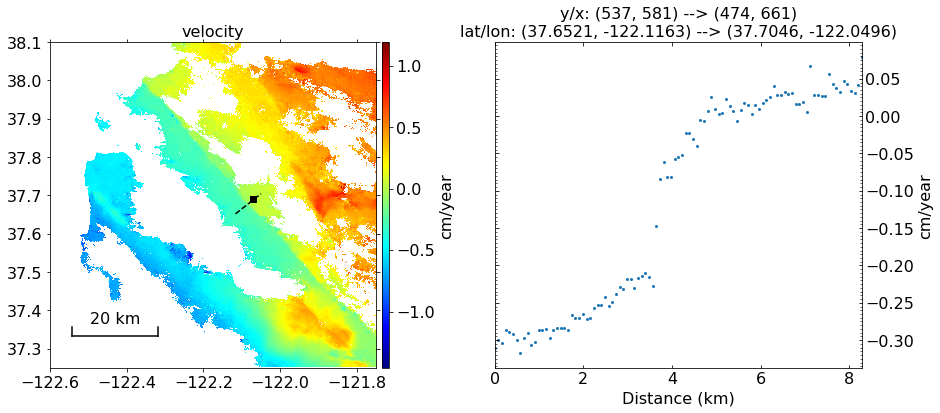

In [44]:
scp_args = 'velocity.h5 --start-lalo 37.5307 -122.3631 --end-lalo 37.9828 -121.7707 '
scp_args = 'velocity.h5 --start-lalo 37.6523 -122.1163 --end-lalo 37.7047 -122.0497 '
plot_transection.main(scp_args.split())

The transect across Hayward fault shows ~2.5 mm/yr fault creep in LOS direction.

# 4. Validation (comparing InSAR with GPS)

MintPy's analysis is independent of GPS observations. This allows validating InSAR products with GPS data when they are available. For this purpose MintPy automatically downloads GPS data over the region of interest from Nevada Geodetic Laboratory at University of Nevada, Reno. To download the GPS data, project the components to InSAR LOS direction and plot them on the InSAR velocity map one can use the following command:    

run view.py in MintPy release version v1.2.3-93, release date 2020-11-27
input file is velocity file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/velocity.h5 in float32 format
file size in y/x: (1021, 1021)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [7.50, 6.00]
read mask from file: maskTempCoh.h5
reading data ...
masking data
data    range: [-1.4619201, 1.1909944] cm/year
display range: [-1.4619201, 1.1909944] cm/year
display data in transparency: 1.0
plot in Lat/Lon coordina

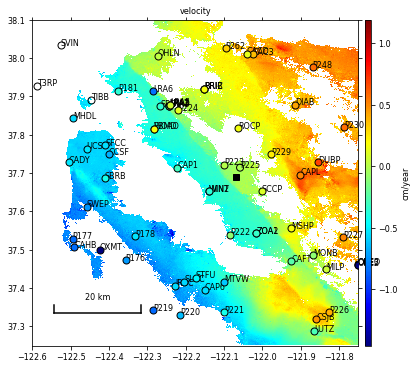

read GPS velocity from file: GPSSitesVel.csv
read InSAR velocity from file: velocity.h5


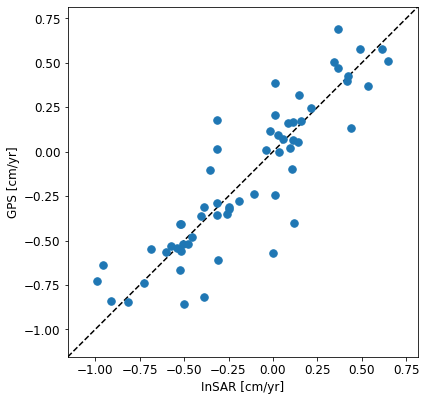

In [8]:
scp_args = 'velocity.h5 velocity --show-gps --ref-gps P225 --gps-comp enu2los --gps-label --fontsize 8'
view.main(scp_args.split())
plot_insar_vs_gps_scatter()

In order to display the GPS station names on the plot add --gps-label to the plot.

# 3.3 Other MintPy functionalities


### 3.3.1 Stand alone scripts for every processing step

Almost all processing steps are callable through running individual command line scripts. As an example one can invert the interferograms using `ifgram_inversion.py  inputs/ifgramStack.h5 -t smallbaselineApp.cfg`.

Or perform the atmospheric delay correction using `tropo_pyaps3.py` or `tropo_phase_elevation.py`.

Or apply the topographic residual correction using `dem_error.py`.

### 3.3.2 Projecting line-of-sight to vertical and horizontal components

If geocoded displacement products from ascending and descending paths are available, `asc_desc2horz_vert.py` script can be called to project the LOS components to Horizontal and vertical components

### 2.3.3 Generate a mask

generate_mask.py can be used to generate a mask based on existing datasets with differnt options to choose a threshold. For example the following command creates a boolean mask which is True for pixels with temporal coherence greater or equal 0.7 and False everywhere else.

`generate_mask.py temporalCoherence.h5 -m 0.7 -o maskTempCoh.h5`

### 2.3.4 Geocoding products which are in radar coordinates

If the stack of interferograms are in radar coordinate system, the time-series inversion and produced products will be generated in radar coordinate system. To geocode the products, one may use `geocode.py`.

Note that the same command with an additional "--geo2radar" option can be used to transform a map in geo-coordinate to the radar coordinate. 

### 2.3.5 Mosaiking multiple geocoded files

image_stitch.py Merges two or more geocoded datasets sharing common area into one. It finds the overlap area and calculates the average offset between the datasets. For example: `image_stitch.py vel_AlosAT422.h5 vel_AlosAT423.h5 vel_AlosAT424.h5 vel_AlosAT425.h5 -o vel_AlosA.h5`

<div class="alert alert-info">
<b>Question :</b> 
Let's assume one has generated Velocity fields for two adjacent tracks. After mosaiking would you expect the two adjacent track be always consistent at the overlap? What may cause inconsistency at the overalp of two adjacent tracks?
</div>

### 2.3.6 Plot transect

plots transect along a line specified with lat-lon coordinates. Check the link below for interactive plot:
https://nbviewer.jupyter.org/github/insarlab/MintPy/blob/main/docs/tutorials/plot_transection.ipynb

view.py velocity.h5  velocity 
run view.py in MintPy release version v1.2.3-93, release date 2020-11-27
input file is velocity file: /Users/yunjunz/data/test/SanFranSenDT42/mintpy/velocity.h5 in float32 format
file size in y/x: (1021, 1021)
input dataset: "['velocity']"
turning glob search OFF for velocity file
num of datasets in file velocity.h5: 2
datasets to exclude (0):
[]
datasets to display (1):
['velocity']
data   coverage in y/x: (0, 0, 1021, 1021)
subset coverage in y/x: (0, 0, 1021, 1021)
data   coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
subset coverage in lat/lon: (-122.600833333, 38.1, -121.75000034, 37.249167007000004)
------------------------------------------------------------------------
colormap: jet
figure title: velocity
figure size : [7.50, 6.00]
read mask from file: maskTempCoh.h5
data    range: [-1.4619201, 1.1909944] cm/year
display range: [-1.4619201, 1.1909944] cm/year
display data in transparency: 1.0
plot in Lat/Lon coordin

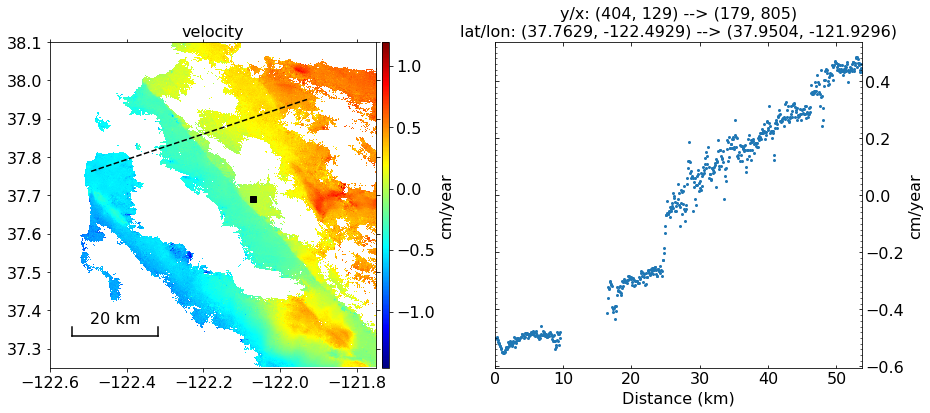

In [9]:
scp_args = 'velocity.h5 --start-lalo 37.7629 -122.4929 --end-lalo 37.9504 -121.9296 '
plot_transection.main(scp_args.split())

### Plot coherence matrix (pixelwise)

Interactive notebook:
https://nbviewer.jupyter.org/github/insarlab/MintPy/blob/main/docs/tutorials/plot_transection.ipynb

open ifgramStack file: ifgramStack.h5
number of all     interferograms: 505
number of dropped interferograms: 14
number of kept    interferograms: 491
number of acquisitions: 114
create figure in size of [9.45, 4.199999999999999] inches
display data in transparency: 1.0
plot in Lat/Lon coordinate
map projection: PlateCarree
plotting image ...
plot scale bar: [0.2, 0.2, 0.1]
plot reference point
plot points of interest
pixel in yx = (858, 512), min/max spatial coherence: 0.18 / 1.00, temporal coherence: 0.71


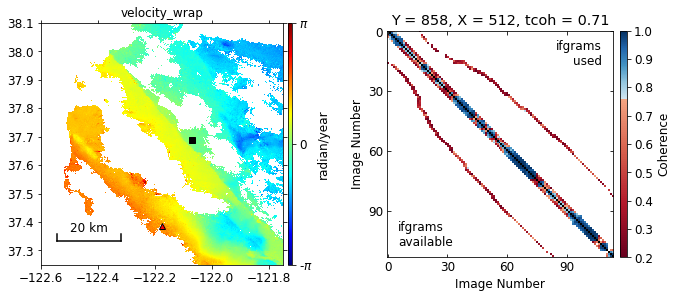

In [10]:
scp_args = 'inputs/ifgramStack.h5 --yx 858 512'
plot_coherence_matrix.main(scp_args.split())

### 2.3.7 Filters (spatial and temporal)

Standard time-series analysis with smallbaselineApp.py avoids any filtering. However, individual scripts are available for users to apply spatial and temporal filtering on the time-series products.

### 2.3.8 Export to other formats

MintPy provides tools to export the products in HDF5 format to other formats including ...

+ ROI_APC (save_roipac.py)
+ GBIS (save_gbis.py)
+ GMT (save_gmt.py)
+ HDF-EOS5 (save_hdfeos5.py)
+ [Google Earth raster (save_kmz.py)](https://mintpy.readthedocs.io/en/latest/google_earth/#2_raster_image)
+ [Google Earth points for displacement time-series (save_kmz_timeseries.py)](https://mintpy.readthedocs.io/en/latest/google_earth/#1_displacement_time-series)

### 2.3.9 view timeseries and other products

view.py : to view and plot the stack of interferogram, coherence, etc
          velocity, temporal coherence, etc
        DEM, products overlaid on DEM and many more

tsview.py : a time-series viewer

timeseries in kmz:

save_kmz_timeseries.py timeseries_demErr.h5 --vel velocity.h5  --tcoh temporalCoherence.h5 --mask maskTempCoh.h5

Check out University of Miami online time-series viewer:
    https://insarmaps.miami.edu/